In [116]:
import os
import time

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from dotenv import load_dotenv

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC

from qiskit.circuit.library import zz_feature_map
from qiskit import generate_preset_pass_manager
from qiskit.primitives import StatevectorSampler

from qiskit_aer import AerSimulator

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Sampler

from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.algorithms import QSVC

In [2]:
algorithm_globals.random_seed = 12345

In [3]:
phone = pd.read_csv('data/cleaned/cleaned_data.csv')

In [4]:
phone

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1994,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1995,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1996,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0


# Le SVC avec un noyau quantique

Après avoir crée des modèles classiques, il est apparu que le plus performant est le SVC. Ce dernier a son équivalent en informatique quantique et c'est sur cet algorithme que nous allons nous concentrer sur cette partie.

L'algorithme SVC en informatique quantique fonctionne de manière similaire à son homologue classique, l'élément qui les différencie est l'utilisation d'un noyau quantique. Afin d'établir le modèle nous allons nous aider de la bibliothèque `qiskit-machine-learning`. Commençons par discuter des données.

## Travail des données

### Filtrage des données

Il ne va pas être possible d'utiliser l'intégralité des données pour entraîner le modèle quantique. Nous allons nous concentrer sur les données les plus corrélées afin de limiter le nombre d'attributs sur lequels nous voulons construire le modèle. La raison principale est que nous voulons utiliser le minimum de qubits possible afin de limiter les erreurs dans le circuit.

Nous avons vu dans l'analyse de données que les données les plus corrélées étaient `ram` et `battery_power`.

In [6]:
data = phone[['ram', 'battery_power', 'price_range', 'px_height', 'px_width']].copy()
data['nb_of_px'] = data['px_height'] * data['px_width']
data = data.drop(columns=['px_height', 'px_width'])
data

,ram,battery_power,price_range,nb_of_px
0,2549,842,1,15120
1,2631,1021,2,1799140
2,2603,563,2,2167308
3,2769,615,2,2171776
4,1411,1821,1,1464096
...,...,...,...,...
1993,668,794,0,2309580
1994,2032,1965,2,1797975
1995,3057,1911,3,1416576
1996,869,1512,0,225120


### Normalisation des données

En informatique quantique, il est préférable de normaliser les données avant de les utiliser pour entraîner un modèle. Nous allons faire une normalisation Min-Max pour commencer.

<div style="padding: 10px; border-left: 5px solid #007ACC; background-color: #E8F4FD;">
  <strong>Info :</strong> Ici le nombre de données est limité à 200. Dans la suite du notebook nous allons avoir besoin de calculer des matrices d'entraînement qui dépendent du nombre de données d'entraînement. Au-delà de 600 le CPU d'un ordinateur personnel normal ne le supporte pas. Avec 200 données on obtient des modèles aussi performants qu'avec 600 données, il a donc été choisi de le limiter à 200 pour des raisons de performances.
</div>

In [8]:
NB_DATA_MAX = 200

X = data[:NB_DATA_MAX].drop(columns=['price_range'])
y = data[:NB_DATA_MAX]['price_range']

X = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)

On vérifie que les valeurs des labels ont bien une distribution homogène.

In [10]:
y.value_counts()

price_range
3    60
1    49
2    49
0    42
Name: count, dtype: int64

On récupère le nombre d'attributs utilisés pour l'entraînement du modèle.

In [12]:
feature_dimension = X.shape[1]

On sépare les données d'entraînement et les données de test.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, shuffle=True, random_state=42)

Nous allons maintenant créer notre premier modèle quantique.quantique

## SVC classique

Regardons de nouveau les scores avec un SVC classique.

In [17]:
svc = SVC()

svc.fit(X_train, y_train)

train_score = svc.score(X_train, y_train)
test_score = svc.score(X_test, y_test)

print(f"Classical SVC classification train score: {train_score}")
print(f"Classical SVC classification test score: {test_score}")

Classical SVC classification train score: 0.91875
Classical SVC classification test score: 0.9


Un SVC classique permettrait de faire une bonne IA d'aide à la décision pour déterminer le prix d'un téléphone portable.

## Création du noyau quantique

Le SVM est un algorithme d'apprentissage supervisé utilisé pour la classification en apprentissage supervisé classique. 

Son principal objectif est de trouver des hyperplans pour séparer les points qui auront au préalable été projetés dans un espace de plus grande dimension. Pour réaliser cette projection, nous allons utiliser un noyau dont le but va être de cartographier les points d'entrée dans l'espace de plus grande dimension, où il sera peut-être plus simple de résoudre le problème initial. Mathématiquement le noyau prend la forme suivante.

$k(\vec{x_{i}}, \vec{x_{j}}) = \langle f(\vec{x_{i}}) \lvert f(\vec{x_{j}}) \rangle$

- $k$ est le **noyau de fonction**
- $\vec{x_{i}}$, $\vec{x_{j}}$ sont des entrées à $n$ dimensions
- $f$ est une **fonction d'application** d'un espace de dimension $n$ vers un espace de dimension $m$
- $\langle a \lvert b \rangle$ représente le produit scalaire

En résulte une matrice donc chaque élément à la $i$-ième ligen et $j$-ième colonne vaut $K_{ij} = k(\vec{x_{i}}, \vec{x_{j}})$. L'idée d'un noyau quantique est d'adapter ce principe en utilisant une fonction d'onde $\phi$ au lieu de la fonction d'application $f$. On aura donc la relation suivante.

$K_{ij} = \lvert \langle \phi(\vec{x_{i}}) \lvert \phi(\vec{x_{j}}) \rangle \lvert ^{2}$

- $\phi$ la fonction d'onde obtenue à partir d'une _feature map_ qui permettra d'encoder la donnée
- $\lvert \langle a \lvert b \rangle \lvert ^{2}$ représente la probabilité que $b$ soit dans l'état $a$ lors d'une mesure. On l'appelle aussi généralement **fidélité**.

La matrice obtenu peut alors être directement injectée dans l'algorithme SVC classique. Dans l'objectif de créer une première matrice quantique, intéressons-nous de plus prêt à la _feature map_ qui va permettre d'encoder les données.

### Feature map

Pour la _feature map_ nous allons utiliser le circuit archétype `ZZFeatureMap` qui nous permet d'encoder des données.

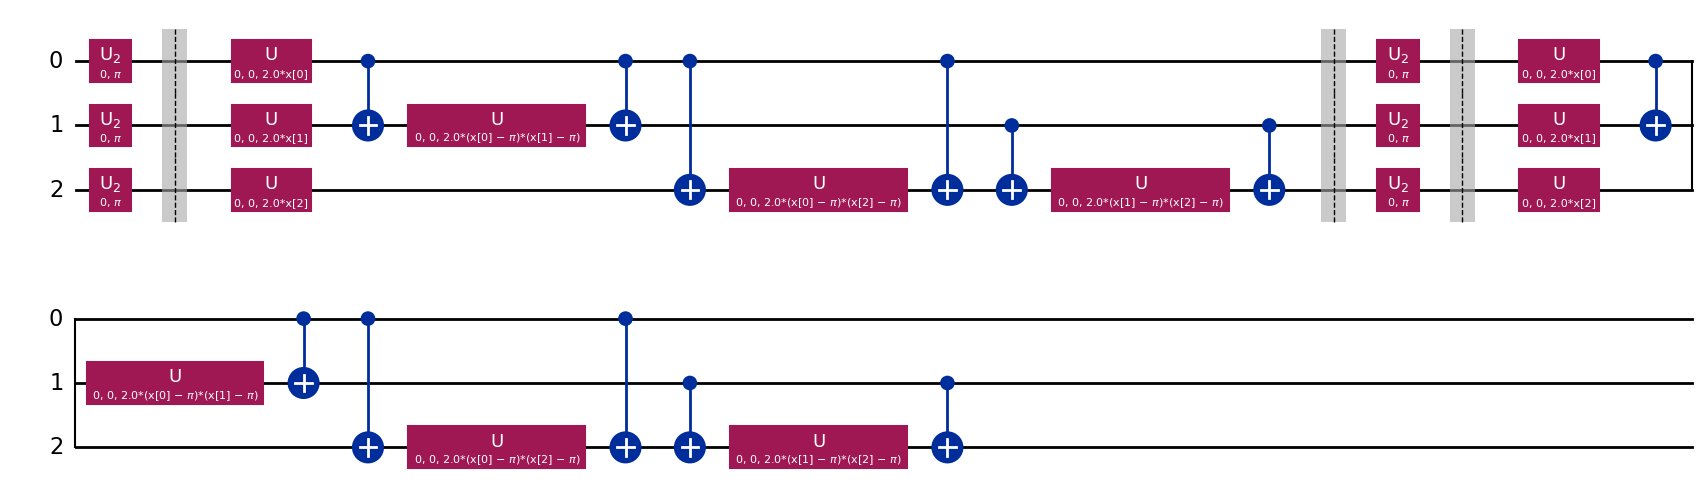

In [21]:
feature_map = zz_feature_map(feature_dimension=feature_dimension, reps=2, entanglement="full", insert_barriers=True)
feature_map.decompose().draw("mpl")

Les valeurs pour les arguments `reps` et `entanglement` sont les valeurs par défaut. Pour le moment `insert_barriers` a la valeur à `True` pour une meilleure visibilité du circuit.

Nous allons travailler sur ce modèle d'IA quantique en plusieurs temps.
- Dans un premier temps nous allons créer un modèle à partir d'un simulateur idéal
- Dans un deuxième temps nous allons créer un modèle à partir d'un simulateur basé sur le QPU IBM Torino. L'objectif est de voir l'influence des erreurs quantiques sur le résultat
- Dans un troisième temps nous allons créer un modèle à partir du QPU IBM Torino.

Commençons par le simulateur idéal.

### StatevectorSampler

Le `StatevectorSampler` est une primitive fournie par Qiskit qui va permettre de simuler une primitive de type `Sampler` avec une simulation de vecteur d'état. Il n'y a pas d'erreur dans ce simulateur tel qu'il peut y en avoir dans un ordinateur quantique.

In [24]:
sampler = StatevectorSampler()

Nous allons utiliser la classe `ComputeUncompute` qui va nous aider à calculer la fidélité entre deux états quantique. Elle calcule la fidélité directement à partir d'un _sampler_ qui sera le paramètre à lui indiquer.

In [26]:
fidelity = ComputeUncompute(sampler=sampler)

Nous allons ensuite utiliser la classe `FidelityQuantumKernel` qui va permettre de calculer le noyau quantique. Son constructeur prend en argument la fidélité ainsi que le circuit quantique qui va déterminer la fonction d'onde de la chaîne de qubits.

In [28]:
quantum_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

On peut ensuite calculer les matrices à partir de la méthode `evaluate` du noyau quantique.

In [30]:
matrix_train = quantum_kernel.evaluate(x_vec=X_train)
matrix_test = quantum_kernel.evaluate(x_vec=X_test, y_vec=X_train)

On peut afficher les matrices obtenues grâce à Matplotlib.

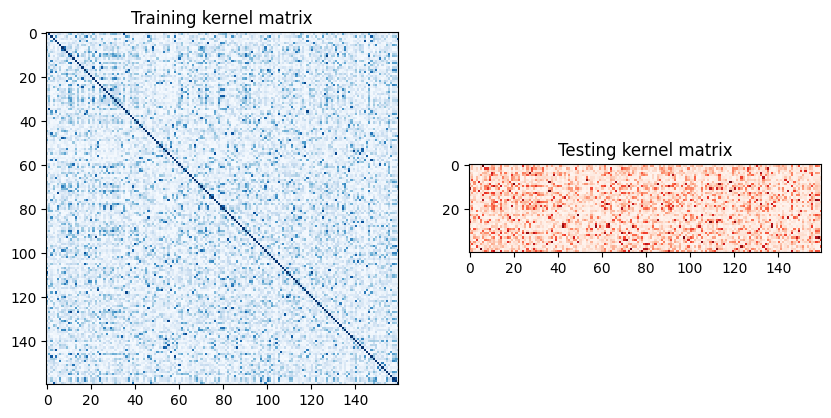

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Training kernel matrix")

axs[1].imshow(np.asmatrix(matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Testing kernel matrix")

plt.show()

Il est possible d'utiliser la matrice calculée avec l'algorithme `SVC` de Scikit-learn en précisant qu'on a précalculé le noyau.

In [34]:
svc = SVC(kernel="precomputed")

svc.fit(matrix_train, y_train)

train_score_quantum_kernel = svc.score(matrix_train, y_train)
test_score_quantum_kernel = svc.score(matrix_test, y_test)

print(f"Justesse obtenue avec les données d'entraînement: {train_score_quantum_kernel}")
print(f"Justesse otebnue avec les données de test: {test_score_quantum_kernel}")

Justesse obtenue avec les données d'entraînement: 0.875
Justesse otebnue avec les données de test: 0.75


La métrique d'évaluation utilisée est la justesse. Sa valeur n'est pas aussi élevé que pour le modèle classique mais elle a des performances honnêtes pour un modèle d'intelligence artificielle quantique. Il peut également être un outil d'aide à la décision. L'intelligence artificielle qui en sera issue sera moins performante que le modèle classique. L'idée étant de créer une IA quantique viable sur un QPU actuel pour le mettre ensuite en production, la justesse paraît alors raisonnable.

Nous avons ici la justesse avec un simulateur idéal. Dans la suite du notebook nous allons essayer de nous rapprocher de ce score en utilisant un QPU réel.

### Sampler issu du QPU IBM Torino

Commençons par récupérer les informations du QPU IBM Torino grâce à une instance.

<div style="padding: 10px; border-left: 5px solid #007ACC; background-color: #E8F4FD;">
  <strong>Info :</strong> Pour cette étape il faut au préalable créer une instance sur IBM Quantum Platform avec son compte IBM. Une fois fais il faut s'assurer que le fichier local.env existe bien en local et lui ajouter les paramètre IBM_TOKEN et IBM_INSTANCE qui vont respectivement stocker la clef API et l'ID de l'instance.
</div>

In [37]:
load_dotenv('local.env')

token = os.getenv('IBM_TOKEN')
instance = os.getenv('IBM_INSTANCE')

QiskitRuntimeService.save_account(
    token=token,
    instance=instance,
    set_as_default=True,
    overwrite=True
)

service = QiskitRuntimeService()
backend = service.backend("ibm_torino")

# Défintion d'un simulateur qui a les mêmes propriétés que l'ordinateur quantique
fake_backend = AerSimulator.from_backend(backend)

On peut maintenant créer un sampler à partir du simulateur.

In [39]:
sampler = Sampler(mode=fake_backend)

On créé ensuite un _pass manager_ qui va nous permettre de transpiler les circuits quantiques pour les adapter au QPU de l'ordinateur. Pour cela nous allons utiliser le générateur de _pass manager_ de Qiskit en lui précisant le QPU sur lequel on travail ainsi que le niveau d'optimisation qu'on veut avoir pour la correction et l'atténuation d'erreurs quantiques. Dans un premier temps nous allons mettre ce paramètre à 0, ce qui signifie qu'il n'y a pas de correction ou d'atténuation.

In [41]:
pass_manager = generate_preset_pass_manager(
    backend=fake_backend,
    optimization_level=0,
)

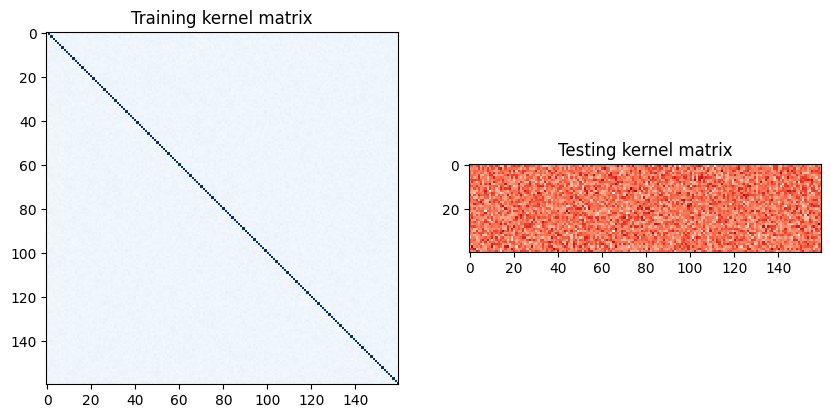

In [42]:
fidelity = ComputeUncompute(
    sampler=sampler,
    pass_manager=pass_manager
)

quantum_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

matrix_train = quantum_kernel.evaluate(x_vec=X_train)
matrix_test = quantum_kernel.evaluate(x_vec=X_test, y_vec=X_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Training kernel matrix")

axs[1].imshow(np.asmatrix(matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Testing kernel matrix")

plt.show()

In [43]:
svc = SVC(kernel="precomputed")

svc.fit(matrix_train, y_train)

train_score_precomputed_kernel = svc.score(matrix_train, y_train)
test_score_precomputed_kernel = svc.score(matrix_test, y_test)

print(f"Precomputed kernel classification train score: {train_score_precomputed_kernel}")
print(f"Precomputed kernel classification test score: {test_score_precomputed_kernel}")

Precomputed kernel classification train score: 1.0
Precomputed kernel classification test score: 0.45


Cette fois-ci les justesses sont loin d'être celles attendues. On voit que les erreurs quantiques du QPU sont suffisantes pour faire chuter un score qui était valable en production vers un score qui n'est plus acceptable.

Nous avons jusqu'ici utilisé une transpilation très basique, sans essayer de corriger ou atténuer les erreurs quantiques. Commençons par améliorer le paramètre `optimization_level` pour la transpilation.

### Optimization level

Regardons l'évolution du circuit ISA en fonction de la valeur du paramètre.

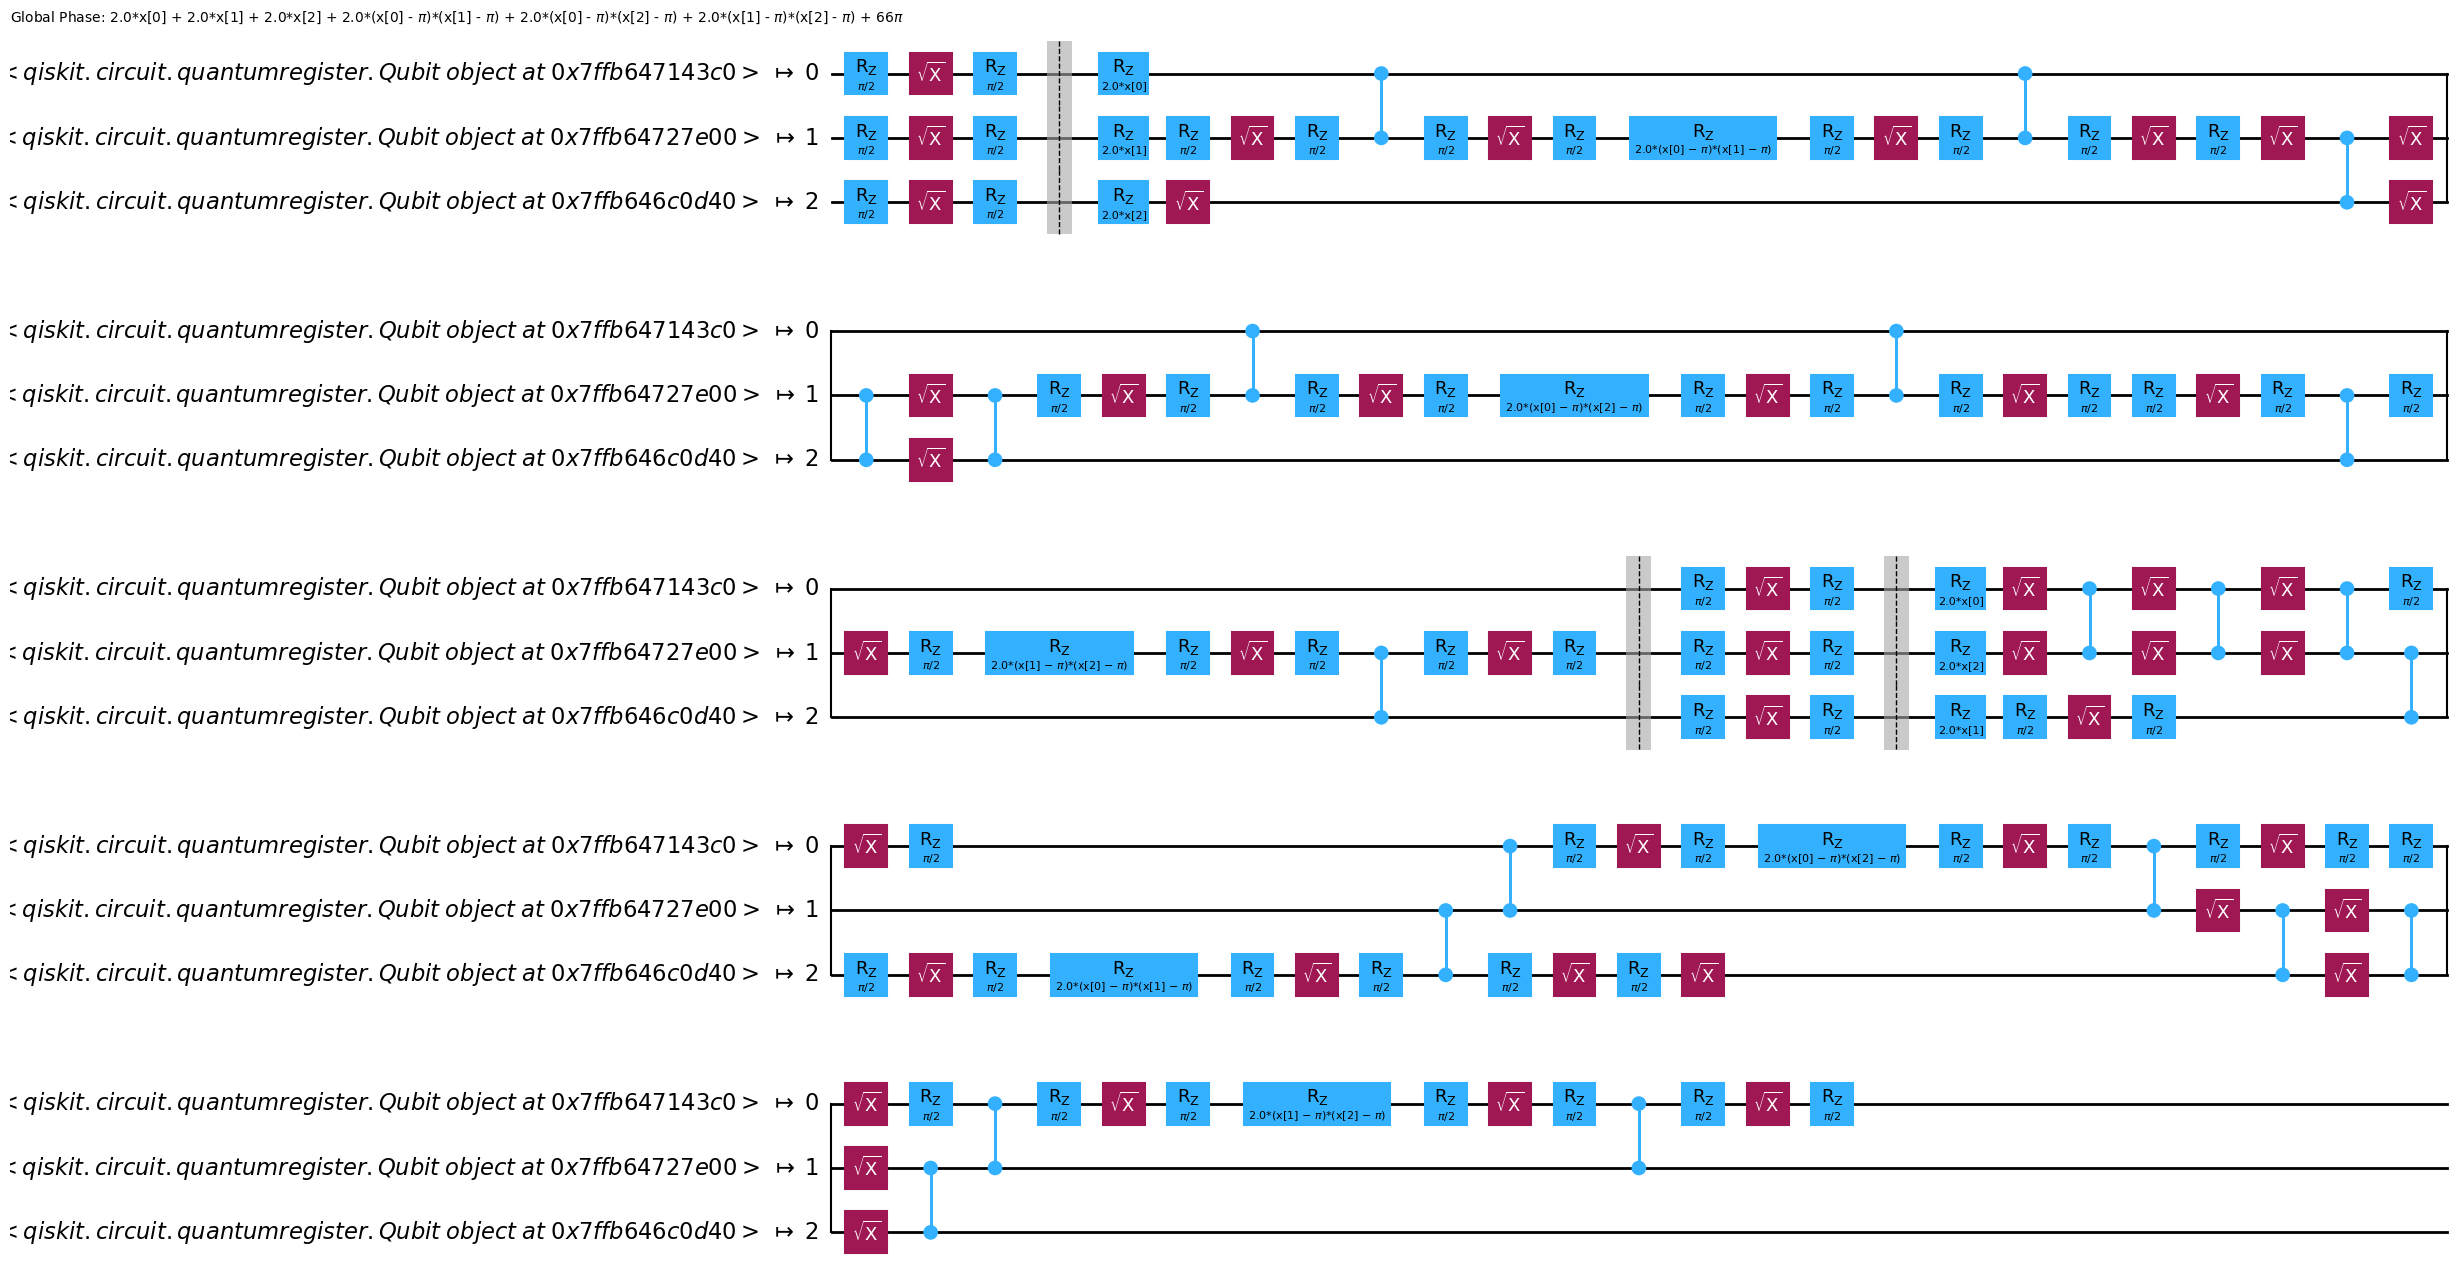

In [46]:
seed_transpiler = 42

pass_manager = generate_preset_pass_manager(
    backend=fake_backend,
    optimization_level=0,
    seed_transpiler=seed_transpiler
)

isa_circuit = pass_manager.run(feature_map)
isa_circuit.draw("mpl", idle_wires=False)

In [47]:
print(f"Profondeur du circuit: {isa_circuit.depth()}")
print(f"Taille du circuit: {isa_circuit.size()}")

Profondeur du circuit: 101
Taille du circuit: 141


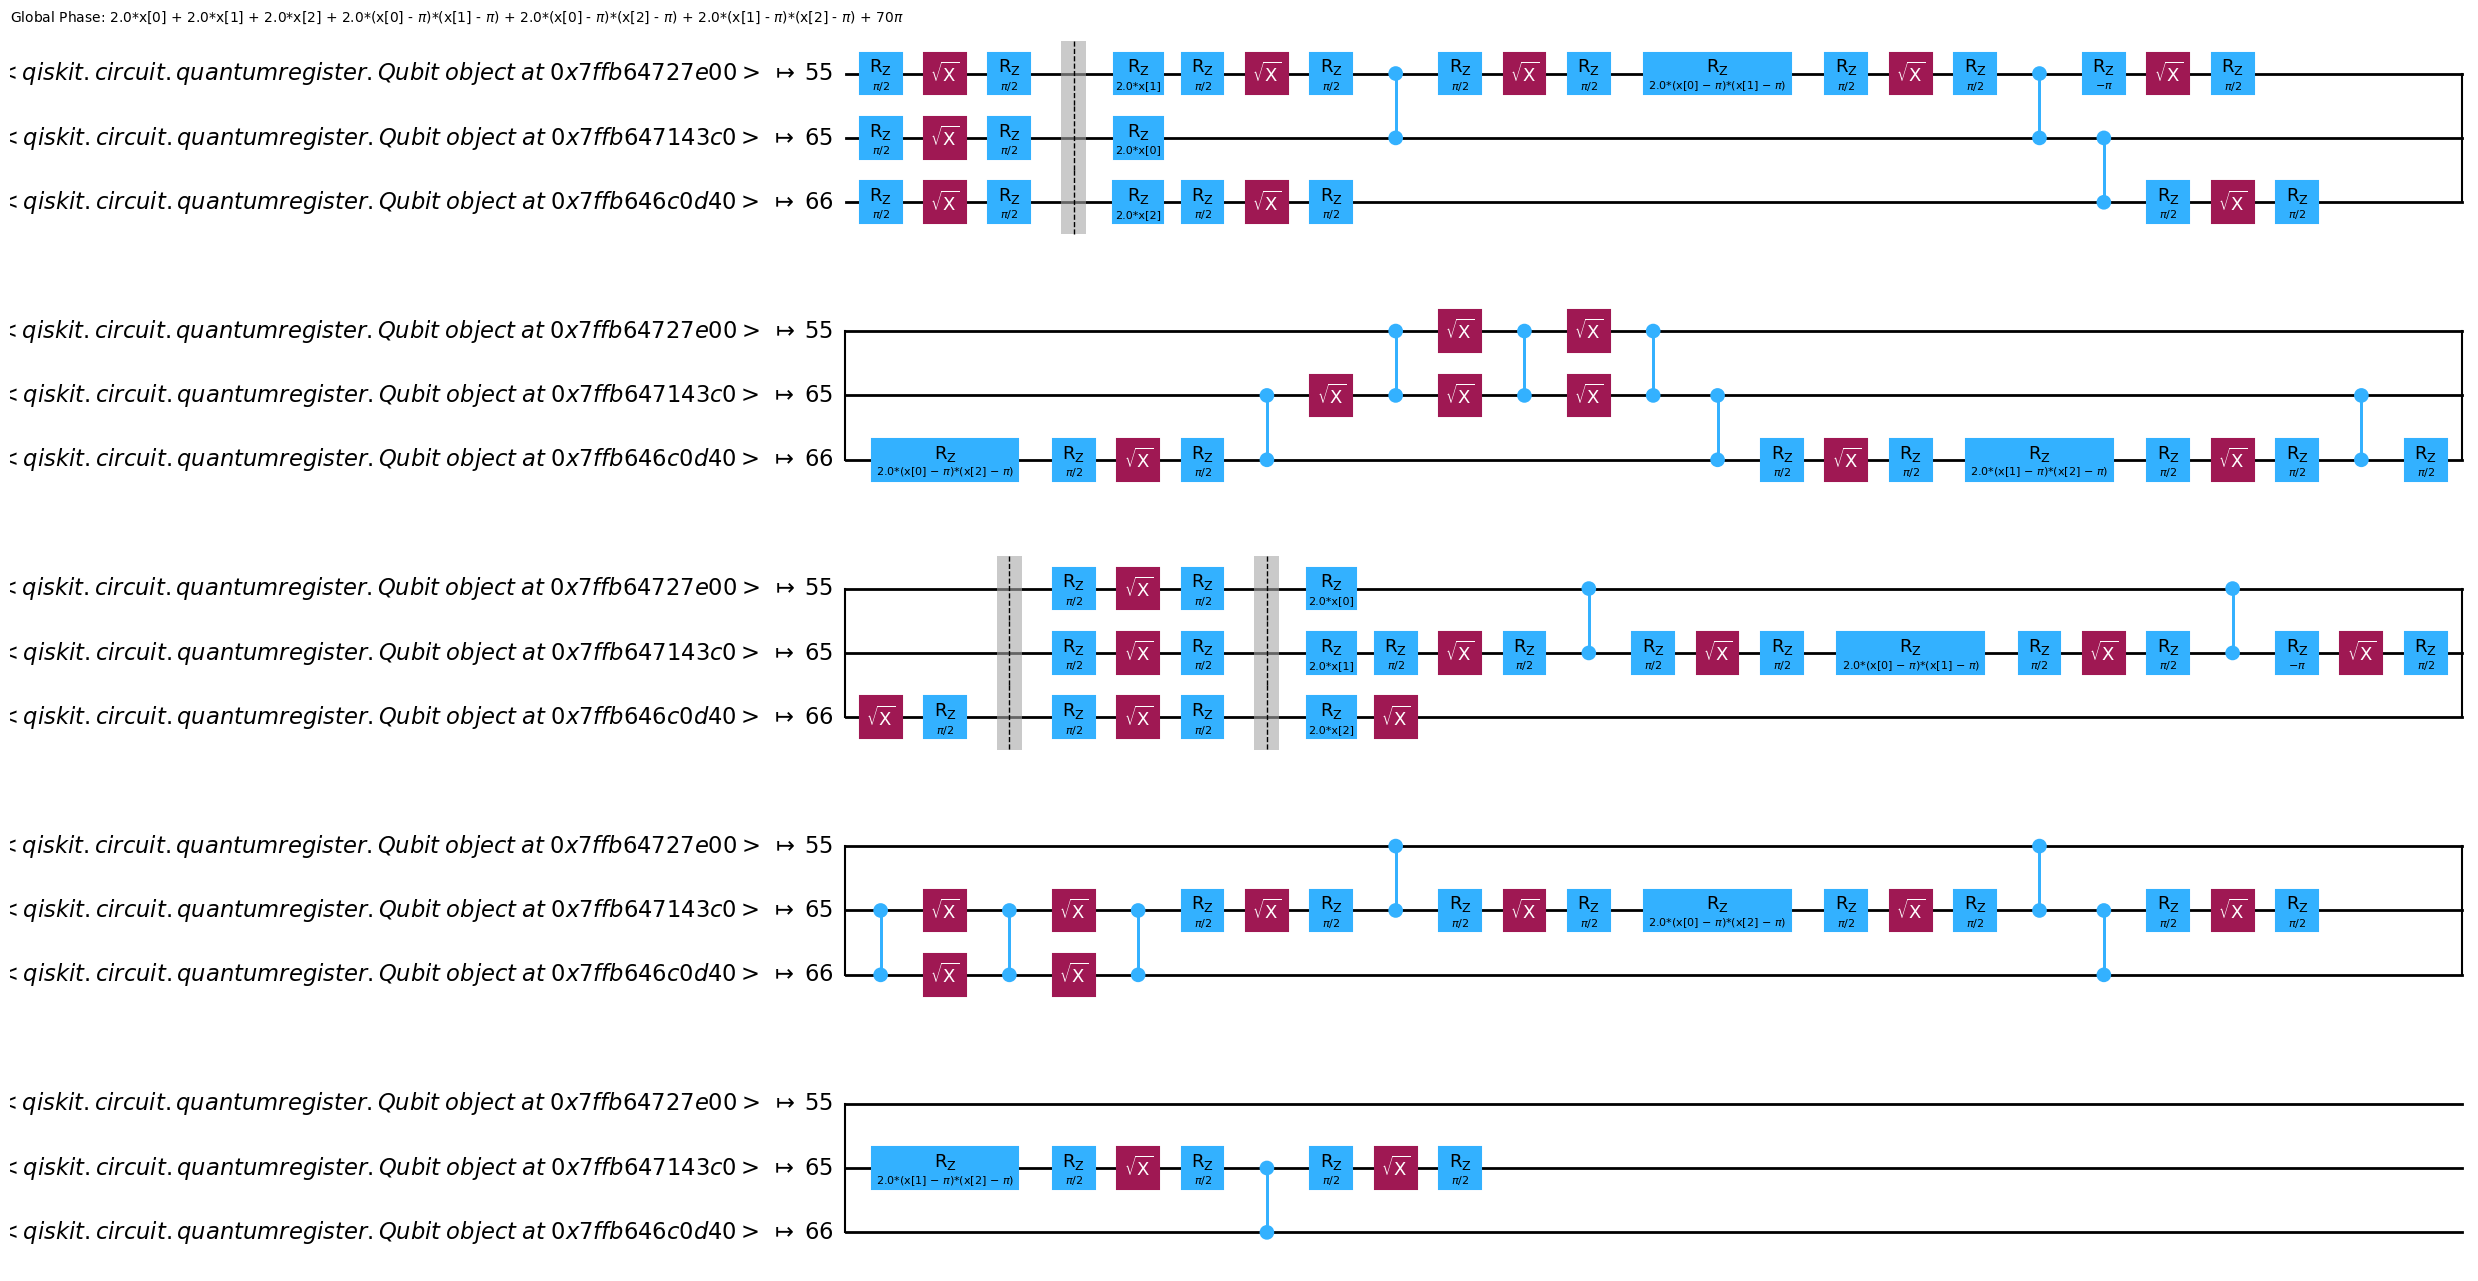

In [48]:
pass_manager = generate_preset_pass_manager(
    backend=fake_backend,
    optimization_level=1,
    seed_transpiler=seed_transpiler
)

isa_circuit = pass_manager.run(feature_map)
isa_circuit.draw("mpl", idle_wires=False)

In [49]:
print(f"Profondeur du circuit: {isa_circuit.depth()}")
print(f"Taille du circuit: {isa_circuit.size()}")

Profondeur du circuit: 91
Taille du circuit: 118


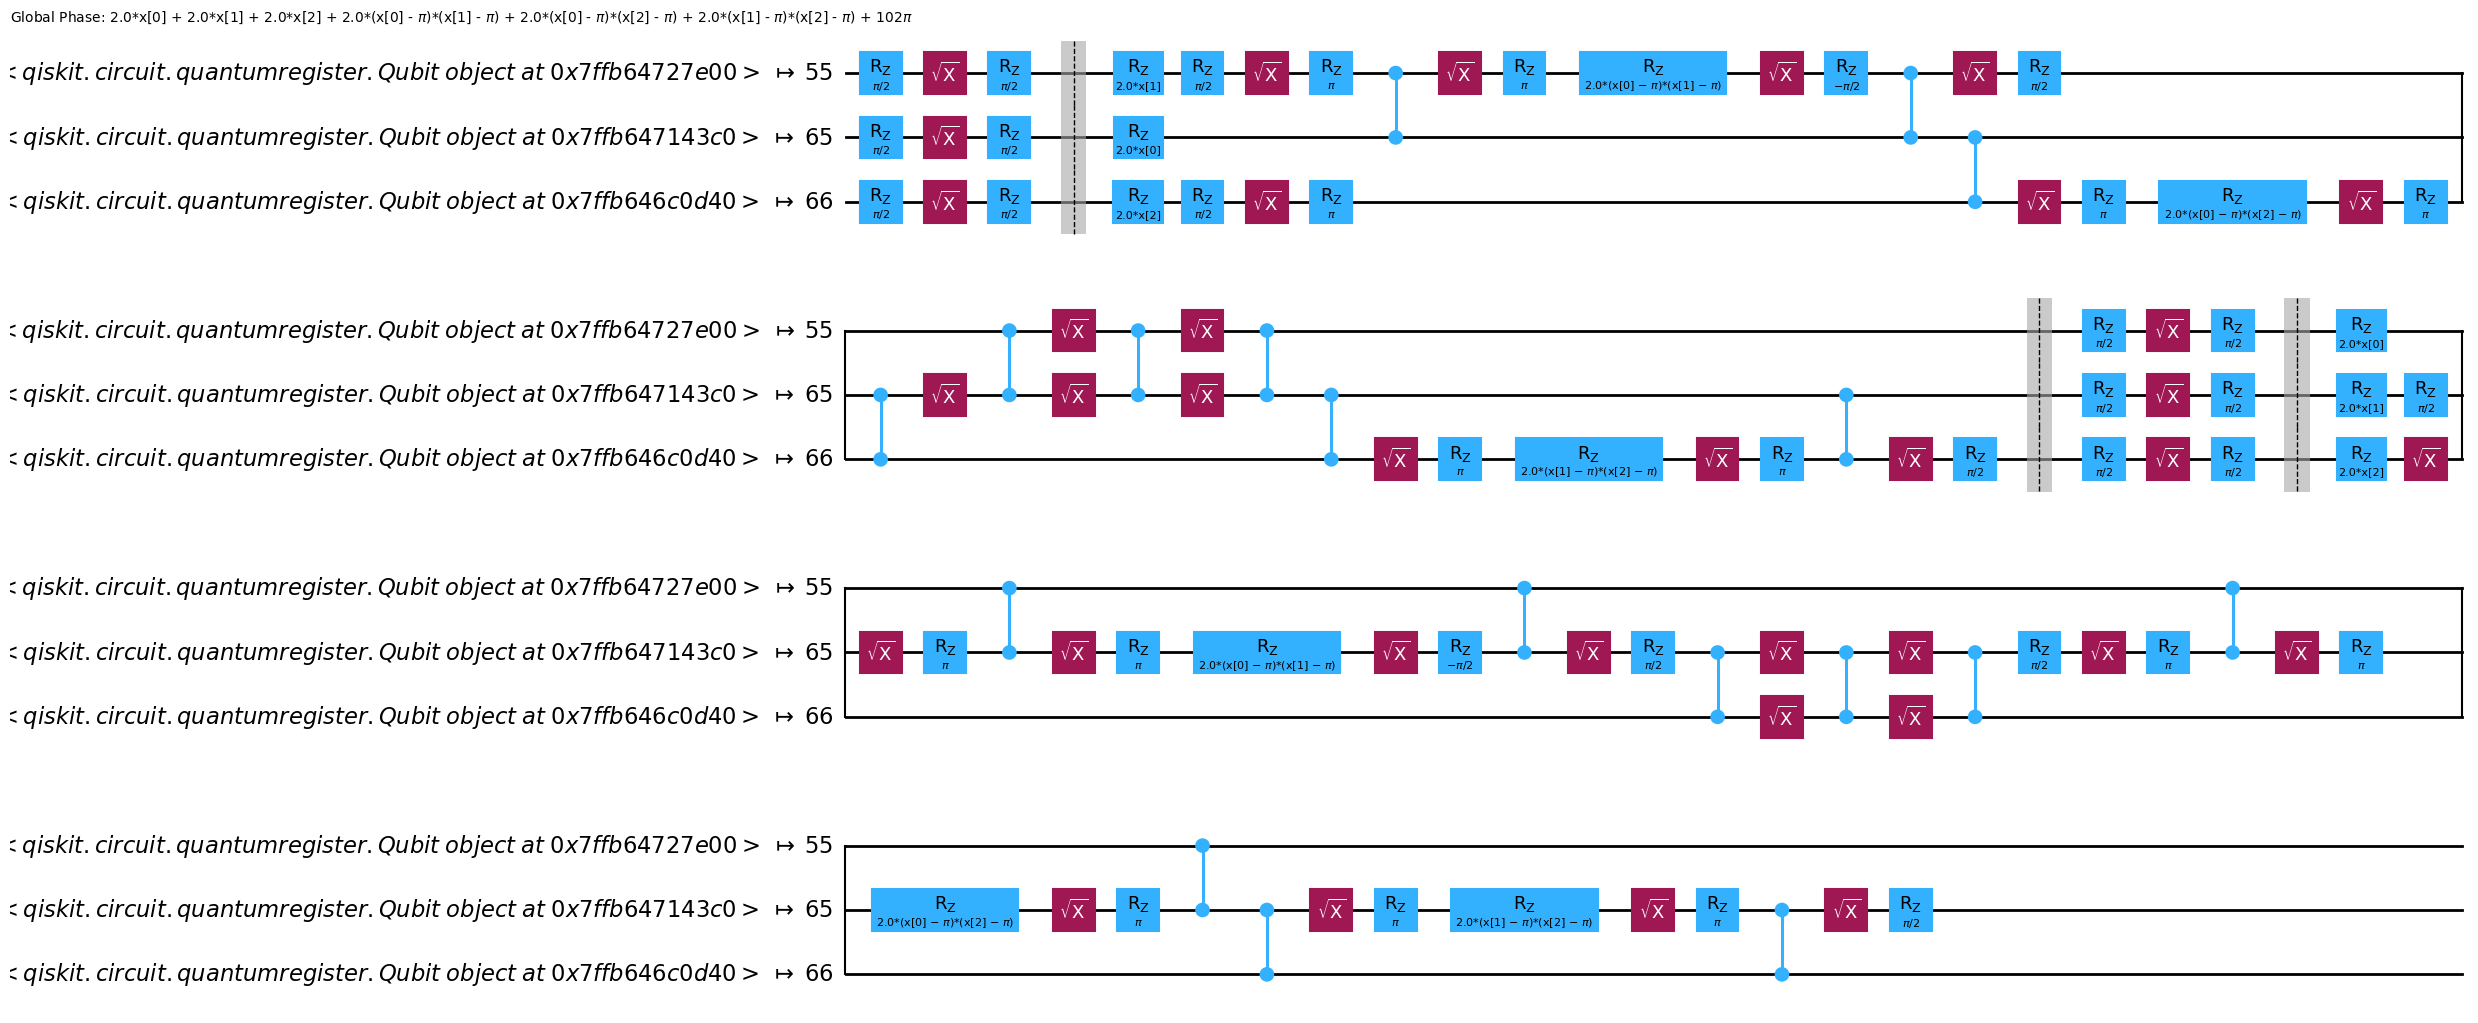

In [50]:
pass_manager = generate_preset_pass_manager(
    backend=fake_backend,
    optimization_level=2,
    seed_transpiler=seed_transpiler
)

isa_circuit = pass_manager.run(feature_map)
isa_circuit.draw("mpl", idle_wires=False)

In [51]:
print(f"Profondeur du circuit: {isa_circuit.depth()}")
print(f"Taille du circuit: {isa_circuit.size()}")

Profondeur du circuit: 76
Taille du circuit: 102


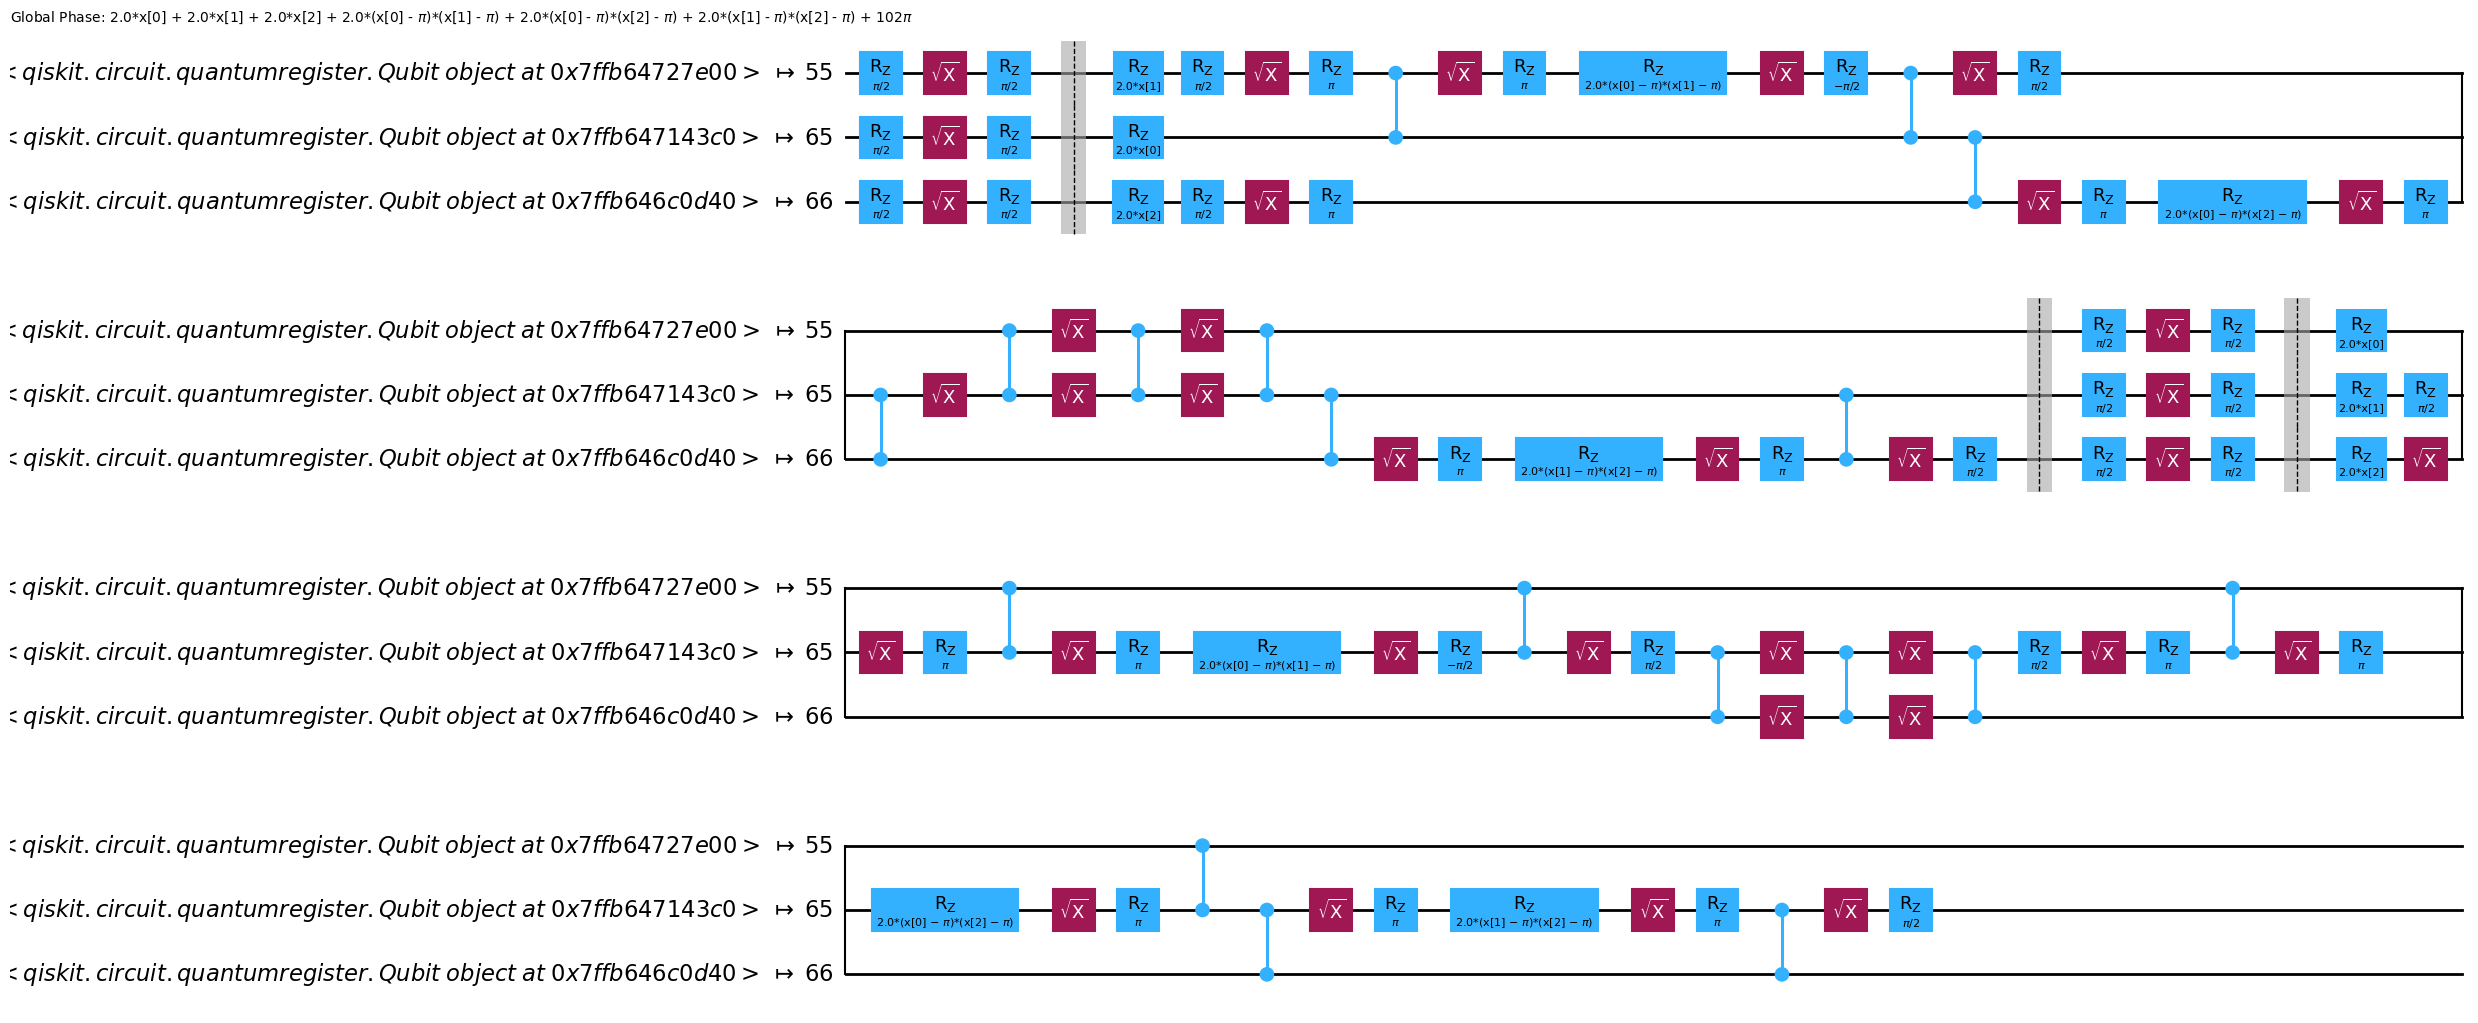

In [52]:
pass_manager = generate_preset_pass_manager(
    backend=fake_backend,
    optimization_level=3,
    seed_transpiler=seed_transpiler
)

isa_circuit = pass_manager.run(feature_map)
isa_circuit.draw("mpl", idle_wires=False)

In [53]:
print(f"Profondeur du circuit: {isa_circuit.depth()}")
print(f"Taille du circuit: {isa_circuit.size()}")

Profondeur du circuit: 76
Taille du circuit: 102


On observe que plus la profondeur et la taille du circuit s'amenuise quand le niveau d'optimisation grandit. Les circuits sont même similaires pour les niveaux d'optimisation 2 et 3, il ne sera donc pas nécessaire d'aller jusqu'au niveau 3 à l'avenir.

Essayons maintenan de voir comment évolue la justesse du modèle en fonction du niveau d'optimisation.

In [55]:
optimization_levels = range(0, 4)

train_scores = []
test_scores = []

for optimization_level in optimization_levels:
    pass_manager = generate_preset_pass_manager(
        backend=fake_backend,
        optimization_level=optimization_level,
        seed_transpiler=seed_transpiler
    )
    fidelity = ComputeUncompute(
        sampler=sampler,
        pass_manager=pass_manager
    )
    quantum_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)
    
    matrix_train = quantum_kernel.evaluate(x_vec=X_train)
    matrix_test = quantum_kernel.evaluate(x_vec=X_test, y_vec=X_train)
    
    svc = SVC(kernel="precomputed")

    svc.fit(matrix_train, y_train)

    train_scores.append(svc.score(matrix_train, y_train))
    test_scores.append(svc.score(matrix_test, y_test))

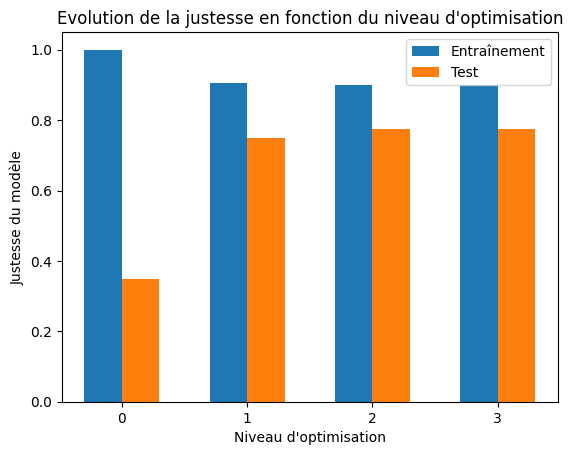

In [56]:
width = 0.30
plt.bar(np.array(optimization_levels)-width/2, train_scores, width=width, label="Entraînement")
plt.bar(np.array(optimization_levels)+width/2, test_scores, width=width, label="Test")
plt.title("Evolution de la justesse en fonction du niveau d'optimisation")
plt.xlabel("Niveau d'optimisation")
plt.ylabel("Justesse du modèle")
plt.xticks(optimization_levels)
plt.legend()
plt.show()

In [57]:
max_test_accuracy = np.max(test_scores)
best_optimization_level = test_scores.index(max_test_accuracy)

print(f"La justesse maximale obtenue est: {max_test_accuracy}")
print(f"Le meilleur niveau d'optimisation est: {best_optimization_level}")

La justesse maximale obtenue est: 0.775
Le meilleur niveau d'optimisation est: 2


Les résultats sont similaires pour les niveaux d'optimisation 2 et 3. Ils sont aussi très bon pour le niveau d'optimisation 1. Jusqu'ici nous n'avons pas fait de validation croisée, il serait intéressant de le faire avoir des résultats plus précis. Comme le niveau d'optimisation 2 et 3 sont similaires et que le niveau d'optimisation 0 n'a vraiment pas de bons résultats, nous ferons la validation croisée que sur les niveaux 1 et 2.

#### Validation croisée

In [60]:
def cross_validation_score(quantum_kernel, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    train_scores = []
    test_scores = []

    folds = list(kf.split(X))

    for fold_id, (train_index, test_index) in enumerate(folds):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        matrix_train = quantum_kernel.evaluate(x_vec=X_train)
        matrix_test = quantum_kernel.evaluate(x_vec=X_test, y_vec=X_train)

        svc = SVC(kernel="precomputed")

        svc.fit(matrix_train, y_train)
                
        train_scores.append(svc.score(matrix_train, y_train))
        test_scores.append(svc.score(matrix_test, y_test))

    return train_scores, test_scores

In [111]:
pass_manager = generate_preset_pass_manager(
    backend=fake_backend,
    optimization_level=1,
    seed_transpiler=seed_transpiler
)

fidelity = ComputeUncompute(
    sampler=sampler,
    pass_manager=pass_manager
)

quantum_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

ol1_train_scores, ol1_test_scores = cross_validation_score(quantum_kernel, X, y)

In [112]:
print(f"Justesse moyenne pour le niveau d'optimisation 1 sur les données d'entraînement: {np.mean(ol1_train_scores)}")
print(f"Justesse moyenne pour le niveau d'optimisation 1 sur les données de test: {np.mean(ol1_test_scores)}")

Justesse moyenne pour le niveau d'optimisation 1 sur les données d'entraînement: 0.89625
Justesse moyenne pour le niveau d'optimisation 1 sur les données de test: 0.7300000000000001


In [63]:
pass_manager = generate_preset_pass_manager(
    backend=fake_backend,
    optimization_level=2,
    seed_transpiler=seed_transpiler
)

fidelity = ComputeUncompute(
    sampler=sampler,
    pass_manager=pass_manager
)

quantum_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

ol2_train_scores, ol2_test_scores = cross_validation_score(quantum_kernel, X, y)

In [64]:
print(f"Justesse moyenne pour le niveau d'optimisation 2 sur les données d'entraînement: {np.mean(ol2_train_scores)}")
print(f"Justesse moyenne pour le niveau d'optimisation 2 sur les données de test: {np.mean(ol2_test_scores)}")

Justesse moyenne pour le niveau d'optimisation 2 sur les données d'entraînement: 0.9025000000000001
Justesse moyenne pour le niveau d'optimisation 2 sur les données de test: 0.7299999999999999


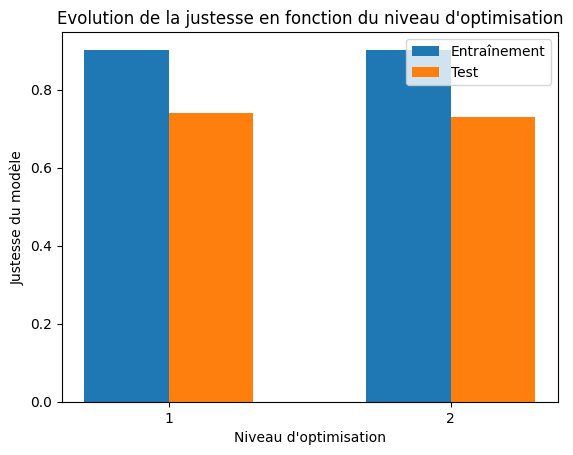

In [65]:
width = 0.30
plt.bar(np.array([1, 2])-width/2, [np.mean(ol1_train_scores), np.mean(ol2_train_scores)], width=width, label="Entraînement")
plt.bar(np.array([1, 2])+width/2, [np.mean(ol1_test_scores), np.mean(ol2_test_scores)], width=width, label="Test")
plt.title("Evolution de la justesse en fonction du niveau d'optimisation")
plt.xlabel("Niveau d'optimisation")
plt.ylabel("Justesse du modèle")
plt.xticks(np.array([1, 2]))
plt.legend()
plt.show()

#### Entraînment du modèle avec un simulateur

In [124]:
pass_manager = generate_preset_pass_manager(
    backend=fake_backend,
    optimization_level=best_optimization_level,
    seed_transpiler=seed_transpiler
)

fidelity = ComputeUncompute(
    sampler=sampler,
    pass_manager=pass_manager
)

quantum_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

qsvc = QSVC(quantum_kernel=quantum_kernel)

qsvc.fit(X, y)

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=False,
     quantum_kernel=<qiskit_machine_learning.kernels.fidelity_quantum_kernel.FidelityQuantumKernel object at 0x7ffa8281d050>,
     random_state=12345, shrinking=True, tol=0.001, verbose=False)

In [132]:
qsvc.save("simulator_qsvc.model")

#### Entraînment du modèle avec IBM Torino

In [134]:
pass_manager = generate_preset_pass_manager(
    backend=backend,
    optimization_level=best_optimization_level,
    seed_transpiler=seed_transpiler
)

fidelity = ComputeUncompute(
    sampler=sampler,
    pass_manager=pass_manager
)

quantum_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

qsvc = QSVC(quantum_kernel=quantum_kernel)

qsvc.fit(X, y)

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=False,
     quantum_kernel=<qiskit_machine_learning.kernels.fidelity_quantum_kernel.FidelityQuantumKernel object at 0x7ffa659c3c50>,
     random_state=12345, shrinking=True, tol=0.001, verbose=False)

In [136]:
qsvc.save("ibm_torino_qsvc.model")